## Initialization

In [1]:
import os
import sys
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import matplotlib.pyplot as plt
from tqdm import tqdm

root_dir = os.getcwd().split("AdversarialNIDS")[0] + "AdversarialNIDS"
sys.path.append(root_dir)

from scripts.logger import LoggerManager
from scripts.analysis.model_analysis import perform_model_analysis

from CICIDS2017.preprocessing.dataset import CICIDS2017
from UNSWNB15.preprocessing.dataset import UNSWNB15

from scripts.models.pytorch.MLP import NetworkIntrusionMLP
from scripts.models.pytorch.CNN import NetworkIntrustionCNN
from scripts.models.pytorch.LSTM import NetworkIntrusionLSTM

from scripts.models.pytorch.train import train
from scripts.models.pytorch.visualization import display_loss

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lm = LoggerManager(log_dir=f"{root_dir}/logs", log_name="TDM")
logger = lm.get_logger()
title = lm.get_title()
logger.info(f"Logger initialized for '{title}'")

2025-11-19 20:59:12,989 - INFO - Logger initialized for 'TDM_20251119_205912'


## Initialization of the Dataset

In [2]:
dataset = CICIDS2017( # [UNSWNB15() or CICIDS2017()]
    dataset_size="full",
    logger=logger
).optimize_memory().encode(attack_encoder="label").scale(scaler="minmax")

2025-11-19 20:59:12,997 - INFO - Downloading dataset: sweety18/cicids2017-full-dataset
2025-11-19 20:59:13,734 - INFO - Loading data
2025-11-19 20:59:27,497 - INFO - Initial dimensions: 2,214,469 rows x 79 columns = 174,943,051 cells
2025-11-19 20:59:42,059 - INFO - ============================================================
2025-11-19 20:59:42,060 - INFO - Preprocessing completed successfully
2025-11-19 20:59:42,061 - INFO - Final dimensions: 1,942,693 rows x 71 columns
2025-11-19 20:59:42,061 - INFO - Total rows removed: 271,776 (12.27%)
2025-11-19 20:59:42,061 - INFO - data retention rate: 87.73%
2025-11-19 20:59:42,062 - INFO - ============================================================
2025-11-19 20:59:42,063 - INFO - Optimizing memory usage of the dataset...
2025-11-19 20:59:42,066 - INFO - Initial memory usage: 1067.15 MB
2025-11-19 20:59:42,747 - INFO - Optimized memory usage: 555.81 MB
2025-11-19 20:59:42,747 - INFO - Memory reduction: 511.34 MB (47.92%)
2025-11-19 20:59:42,

In [3]:
X_train, X_val, y_train, y_val = dataset.subset(size=50000, multi_class=True).split(
    one_hot=True,
    apply_smote=True,
    to_tensor=True
)

2025-11-19 21:00:07,569 - INFO - Subsetting dataset to size: 50000...
2025-11-19 21:00:07,579 - INFO - Class distribution before subsetting:
2025-11-19 21:00:07,579 - INFO -   Class 0: 1528113 samples
2025-11-19 21:00:07,580 - INFO -   Class 1: 1953 samples
2025-11-19 21:00:07,581 - INFO -   Class 2: 128016 samples
2025-11-19 21:00:07,581 - INFO -   Class 3: 193745 samples
2025-11-19 21:00:07,582 - INFO -   Class 4: 11 samples
2025-11-19 21:00:07,582 - INFO -   Class 5: 36 samples
2025-11-19 21:00:07,583 - INFO -   Class 6: 90819 samples
2025-11-19 21:00:07,644 - INFO - Subsetted dataset to size: 30568
2025-11-19 21:00:07,719 - INFO - Splitting dataset into training and testing sets...
2025-11-19 21:00:07,725 - INFO - Class distribution before SMOTE:
2025-11-19 21:00:07,726 - INFO -   Class 0: 5741 samples
2025-11-19 21:00:07,726 - INFO -   Class 1: 1563 samples
2025-11-19 21:00:07,727 - INFO -   Class 2: 5702 samples
2025-11-19 21:00:07,728 - INFO -   Class 3: 5674 samples
2025-11-19 

In [4]:
# Create DataLoaders
train_dataset = TensorDataset(X_train.to(device), y_train.to(device))
val_dataset = TensorDataset(X_val.to(device), y_val.to(device))

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
input_size = train_loader.dataset.tensors[0].shape[1]
num_classes = train_loader.dataset.tensors[1].shape[1]
print(f"Input size: {input_size}, Num classes: {num_classes}")  

criterion = nn.CrossEntropyLoss()

Input size: 70, Num classes: 7


## Multi Layers Perceptron (MLP)

In [6]:
model_mlp = NetworkIntrusionMLP(input_size=input_size, num_classes=num_classes).to(device)
logger.info(f"MLP Model initialized with {model_mlp.num_params()} parameters")

learning_rate_mlp = 1e-2
num_epochs_mlp = 100

optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=learning_rate_mlp)
scheduler_mlp = optim.lr_scheduler.ReduceLROnPlateau(optimizer_mlp, mode='min', factor=0.8, patience=10, min_lr=1e-5)

2025-11-19 21:00:08,109 - INFO - MLP Model initialized with 20519 parameters


In [7]:
model_mlp, train_losses_mlp, val_losses_mlp = train(
    model=model_mlp,
    optimizer=optimizer_mlp,
    scheduler=scheduler_mlp,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_mlp
)

Loss: 1.2028, Val Loss: 1.2190, LR: 0.010000: 100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


2025-11-19 21:01:42,975 - INFO - Plotting loss curve...
2025-11-19 21:01:43,734 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/loss_img/TDM_20251119_205912_MLP_loss.png


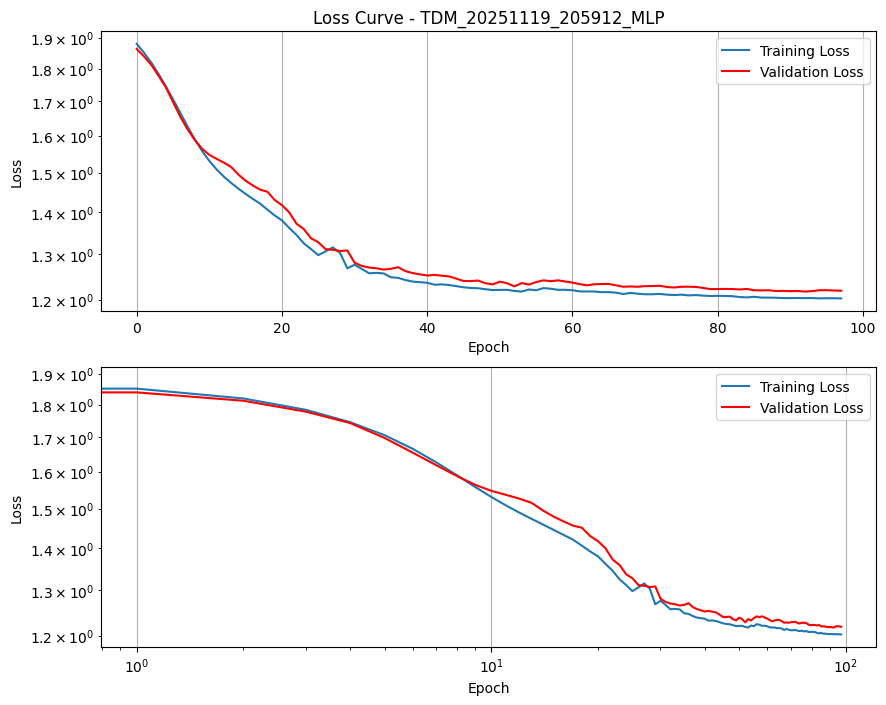

In [8]:
display_loss(
    list_epoch_loss=train_losses_mlp,
    list_val_loss=val_losses_mlp,
    title=f"{title}_MLP",
    dir=root_dir,
    logger=logger,
    epoch_min=2
)

2025-11-19 21:01:43,959 - INFO - Running analysis for PyTorch model: TDM_20251119_205912_MLP on device: cuda:0


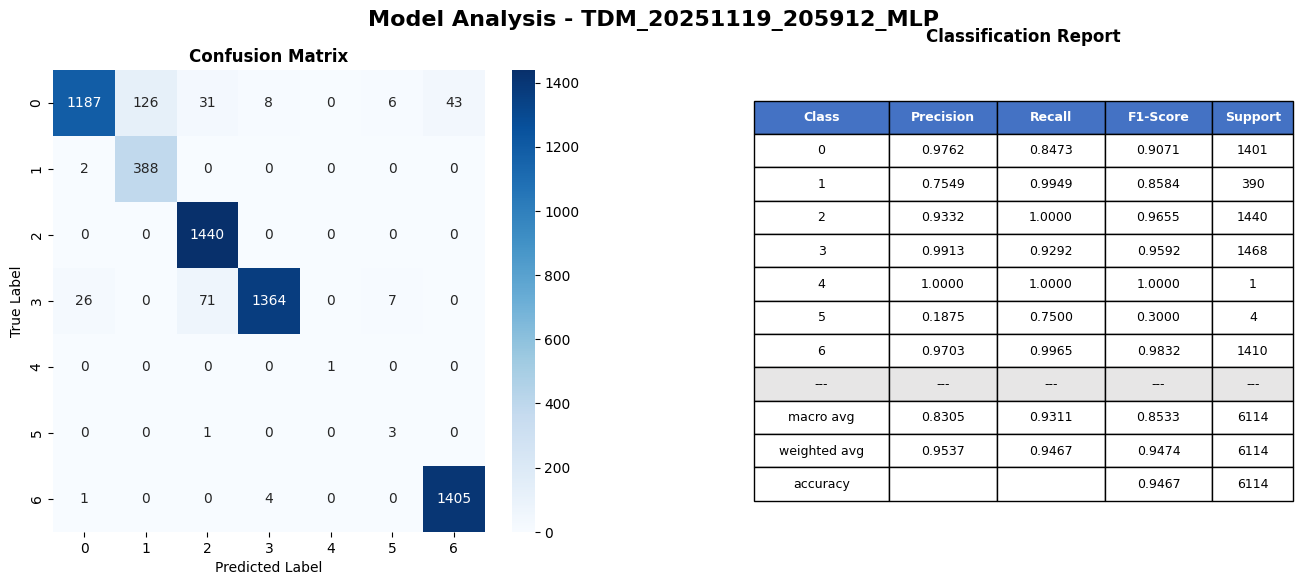

In [9]:
cm, cr = perform_model_analysis(
    model=model_mlp,
    X_test=X_val,
    y_test=y_val,
    logger=logger,
    model_name=f"{title}_MLP",
    dir=root_dir,
    plot=True,
    device=device
)

## Convolutional Neural Network (CNN)

In [10]:
model_cnn = NetworkIntrustionCNN(input_channels=1, input_size= input_size, num_classes=num_classes).to(device)
logger.info(f"CNN Model initialized with {model_cnn.num_params()} parameters")

learning_rate_cnn = 1e-2
num_epochs_cnn = 100

optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=learning_rate_cnn)
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='min', factor=0.8, patience=10, min_lr=1e-5)

2025-11-19 21:01:44,572 - INFO - CNN Model initialized with 95239 parameters


In [11]:
model_cnn, train_loss_cnn, val_loss_cnn = train(
    model=model_cnn,
    optimizer=optimizer_cnn,
    scheduler=scheduler_cnn,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_cnn
)

Loss: 1.2697, Val Loss: 1.2916, LR: 0.008000: 100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


2025-11-19 21:03:27,302 - INFO - Plotting loss curve...
2025-11-19 21:03:27,937 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/loss_img/TDM_20251119_205912_CNN_loss.png


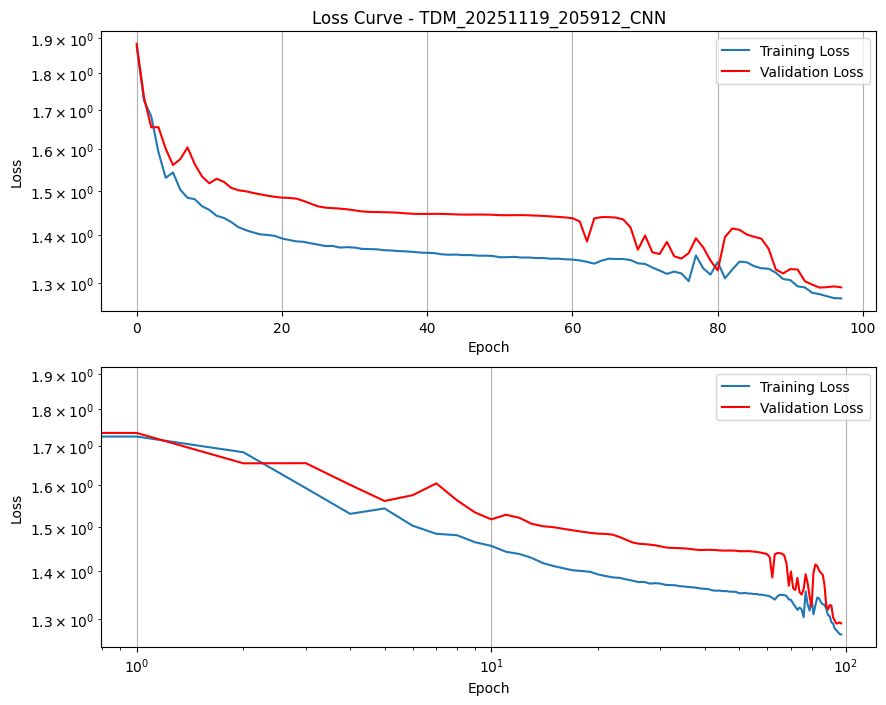

In [12]:
display_loss(
    train_loss_cnn,
    val_loss_cnn,
    title=f"{title}_CNN",
    dir=root_dir,
    logger=logger,
    epoch_min=2
)

2025-11-19 21:03:28,154 - INFO - Running analysis for PyTorch model: TDM_20251119_205912_CNN on device: cuda:0


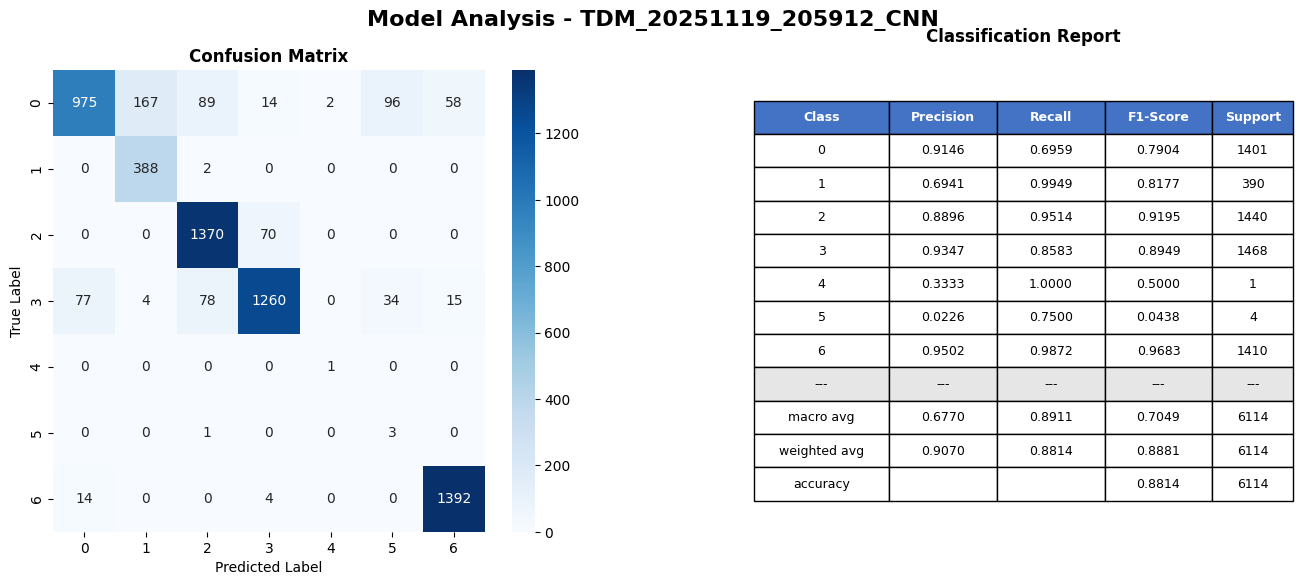

In [13]:
cm, cr = perform_model_analysis(
    model=model_cnn,
    X_test=X_val,
    y_test=y_val,
    model_name=f"{title}_CNN",
    dir=root_dir,
    plot=True,
    logger=logger,
    device=device
)

## Long Short-Term Memory (LSTM)

In [14]:
model_lstm = NetworkIntrusionLSTM(input_size=input_size, hidden_size=64, num_layers=3, num_classes=num_classes).to(device)
logger.info(f"LSTM Model initialized with {model_lstm.num_params()} parameters")

learning_rate_lstm = 1e-2
num_epochs_lstm = 100

optimizer_lstm = optim.Adam(model_lstm.parameters(), lr=learning_rate_lstm)
scheduler_lstm = optim.lr_scheduler.ReduceLROnPlateau(optimizer_lstm, mode='min', factor=0.8, patience=10, min_lr=1e-5)

2025-11-19 21:03:28,773 - INFO - LSTM Model initialized with 103687 parameters


In [15]:
model_lstm, train_loss_lstm, val_loss_lstm = train(
    model=model_lstm,
    optimizer=optimizer_lstm,
    scheduler=scheduler_lstm,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=num_epochs_lstm
)

Loss: 1.3444, Val Loss: 1.3889, LR: 0.006400: 100%|██████████| 100/100 [02:15<00:00,  1.36s/it]


2025-11-19 21:05:44,359 - INFO - Plotting loss curve...
2025-11-19 21:05:44,997 - INFO - Loss curve saved as /media/alexin/MStock/Documents/Cours/TelecomSE/FISE2/Semestre 7/Projet/AdversarialNIDS/loss_img/TDM_20251119_205912_LSTM_loss.png


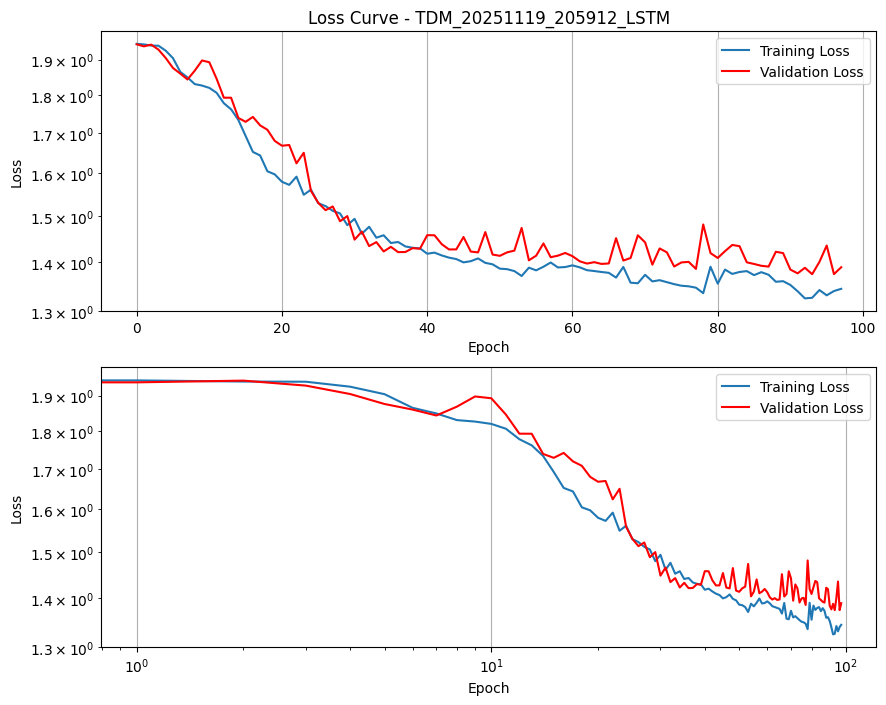

In [16]:
display_loss(
    train_loss_lstm, 
    val_loss_lstm, 
    title=f"{title}_LSTM",
    dir=root_dir, 
    logger=logger,
    epoch_min=2
)

2025-11-19 21:05:45,214 - INFO - Running analysis for PyTorch model: TDM_20251119_205912_LSTM on device: cuda:0


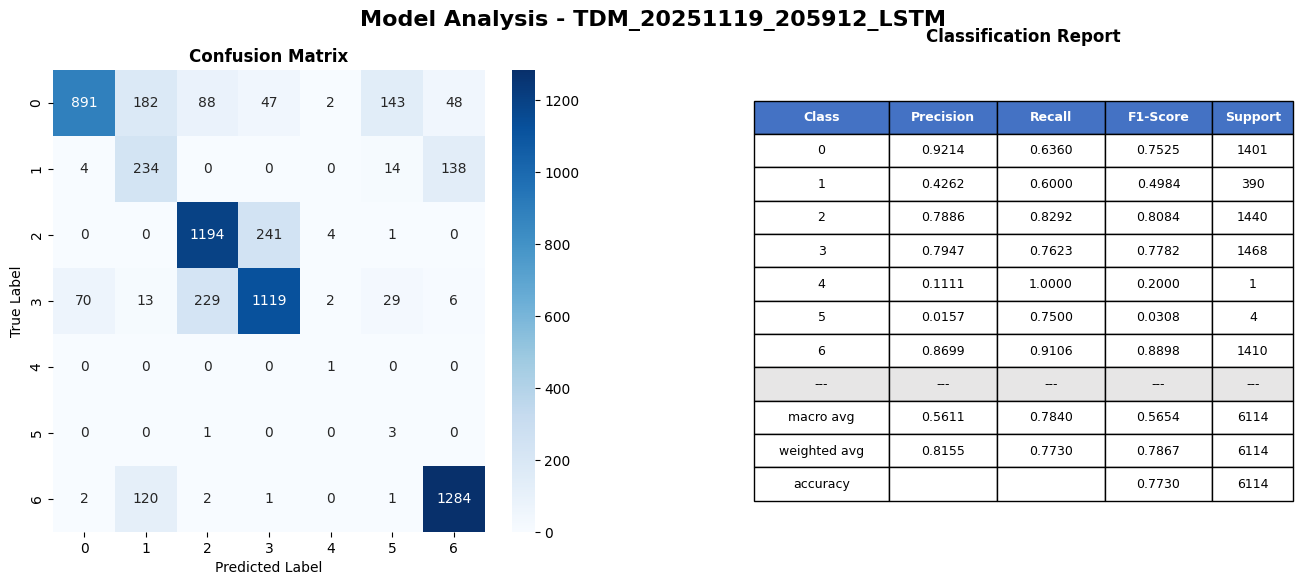

In [17]:
cm, cr = perform_model_analysis(
    model=model_lstm,
    X_test=X_val,
    y_test=y_val,
    model_name=f"{title}_LSTM",
    dir=root_dir,
    plot=True,
    logger=logger,
    device=device
)